In [12]:
import os
from typing import Tuple, Callable, Dict, Optional, List

import numpy as np
import pandas as pd
import scipy.sparse as sp

np.random.seed(42)

columns_name = ['user_id','item_id','impression_list','data']

dataset_lenght = pd.read_csv("D:\Scuola\RecSys\Challenge\RecSys\dati\data_ICM_length.csv", 
                                    sep=",", 
                                    dtype={0:int, 1:int, 2:int},
                                    engine='python'
                                    )
dataset_type = pd.read_csv("D:\Scuola\RecSys\Challenge\RecSys\dati\data_ICM_type.csv", 
                                    sep=",", 
                                    dtype={0:int, 1:int, 2:int},
                                    engine='python'
                                    )

dataset = pd.read_csv("D:\Scuola\RecSys\Challenge\RecSys\dati\interactions_and_impressions.csv", sep=",")
test_users = pd.read_csv('D:\Scuola\RecSys\Challenge\RecSys\dati\data_target_users_test.csv',sep = ',')

C:\Users\Manuel\AppData\Local\Temp\ipykernel_6128\2435214679.py:23: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("D:\Scuola\RecSys\Challenge\RecSys\dati\interactions_and_impressions.csv", sep=",")


In [13]:
def build_URM_impr_notSeen(URM, URM_impr):
    URM = URM.astype('float64')
    URM_impr = URM_impr.astype('float64')
    
    URM_dense = URM.todense()
    URM_impression_dense=URM_impr.todense()
    mask = np.logical_and(URM_dense==1.0,URM_impression_dense == 1.0)
    URM_impression_dense[mask] = 0
    return sp.csr_matrix(URM_impression_dense)

In [14]:
def build_URM_impression(df : pd.DataFrame, num_users, num_items):
    df_impressions = df.drop(columns = ['Data','ItemID'])
    df_impressions.dropna(inplace=True)
    
    df_impressions = df_impressions.groupby(by=['UserID'])['Impressions'].apply(list).reset_index()

    def helper(list_string):
        data = []
        for string in list_string:
            stuff = string.split(',')
            for s in stuff:
                int(s)
                data.append(int(s))
        return data

    df_impressions['Impressions']= df_impressions['Impressions'].apply(helper)
    df_impressions = df_impressions.groupby(by=['UserID'])['Impressions'].apply(np.array).reset_index()
    df_impressions['Impressions'] = df_impressions['Impressions'].apply(np.concatenate)
    df_impressions['Impressions'] = df_impressions['Impressions'].apply(np.unique)

    A  = np.zeros(shape=(num_users,num_items))
    for i in df_impressions['UserID']:
        for j in df_impressions.iloc[i]['Impressions']:
            A[i,j]=1

    URM_impression = sp.csr_matrix(A)
    return URM_impression

In [15]:
def build_URM_mixed(URM, URM_impr):
    URM = URM.astype('float64')
    URM_impr = URM_impr.astype('float64')
    
    URM_dense = URM.todense()
    URM_impression_dense=URM_impr.todense()
    mask = np.logical_and(URM_dense==0.0,URM_impression_dense == 1.0)
    URM_dense[mask] = 0.5
    return sp.csr_matrix(URM_dense)

In [16]:
from Data_manager.Build_Matrix.Data_import import build_ICM_type,build_ICM_lengh_kmeans,build_URM_ICM_onlyURM_item
ICM_TYPE  = build_ICM_type(dataset_type)
ICM_LENGHT = build_ICM_lengh_kmeans(dataset_lenght)
URM_ALL,ICM_ALL = build_URM_ICM_onlyURM_item(dataset,dataset_type,dataset_lenght)

d:\Scuola\RecSys\Challenge\RecSys\Data_manager\Build_Matrix\Data_import.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.data = kmeans.labels_.copy()


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from Recommenders.DataIO import DataIO
from skopt.space import Real, Integer, Categorical
from numpy import linalg as LA
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender



seed = 0

In [18]:
unique_users = dataset.UserID.unique()
unique_items = dataset.ItemID.unique()
    
num_users = URM_ALL.get_shape()[0]
num_items = URM_ALL.get_shape()[1]

URM_impression = build_URM_impression(dataset, num_users, num_items)
URM_impression_notSeen = build_URM_impr_notSeen(URM_ALL,URM_impression)

In [19]:
URM_impression

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 1605042 stored elements in Compressed Sparse Row format>

In [20]:
URM_impression_notSeen

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 1373972 stored elements in Compressed Sparse Row format>

1
1.0
0


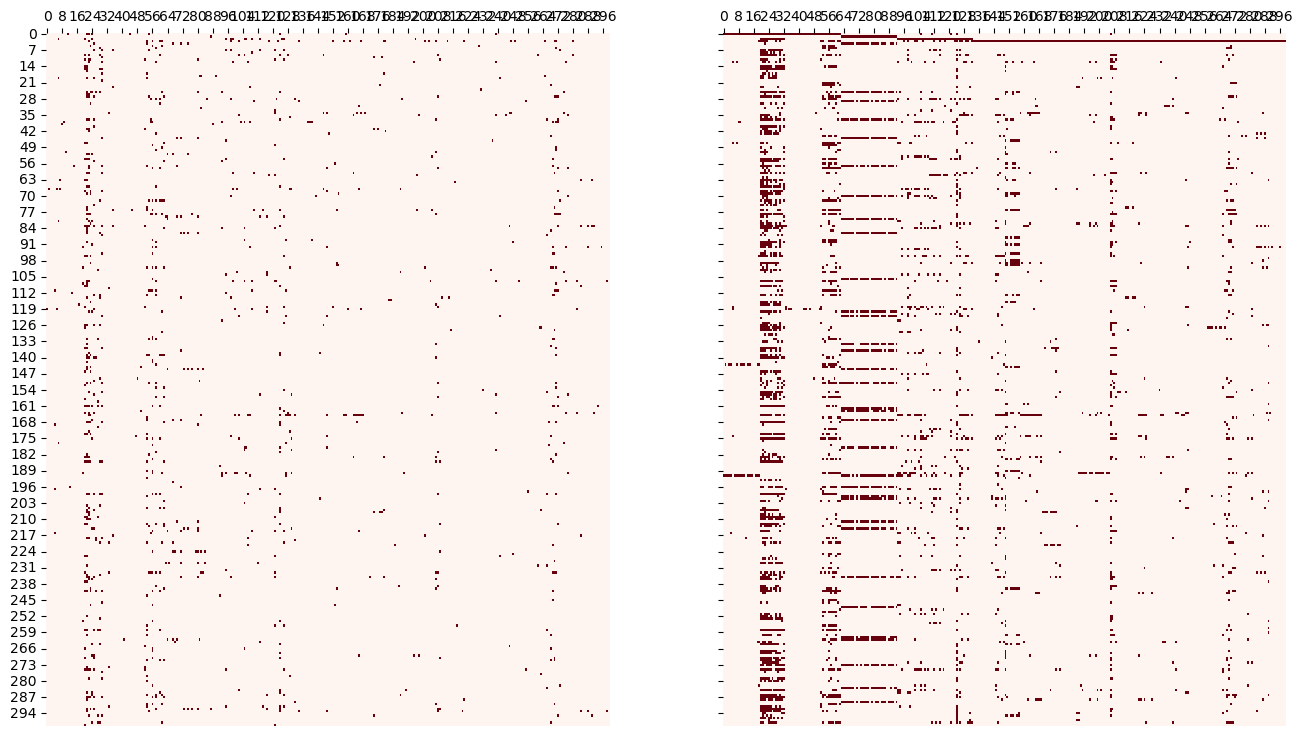

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


simMatrix1 = URM_ALL
simMatrix2 = URM_impression

simMatrix1_max = simMatrix1.max()
simMatrix2_max = simMatrix2.max()
vmax = np.max([simMatrix1_max, simMatrix2_max])

print(simMatrix1_max)
print(simMatrix2_max)
print(np.argmax([simMatrix1_max, simMatrix2_max]))

f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
sns.heatmap(simMatrix1[:300, :300].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds")
sns.heatmap(simMatrix2[:300, :300].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2, cmap="Reds")
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")

In [22]:
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_ALL, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
import scipy.sparse as sps
stacked_URM_train = sps.vstack([URM_train,  ICM_TYPE.T,URM_impression_notSeen])
stacked_URM_train_validation = sps.vstack([URM_train_validation, ICM_TYPE.T, URM_impression_notSeen])
stacked_URM_ALL = sps.vstack([URM_ALL, ICM_TYPE.T, URM_impression_notSeen])


EvaluatorHoldout: Ignoring 742 ( 1.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 356 ( 0.9%) Users that have less than 1 test interactions


In [23]:
param_SLIM = {'topK': 543, 'l1_ratio': 0.008893304471868306, 'alpha': 0.00395073367842559}

recommender_train = SLIMElasticNetRecommender(URM_train.tocsr())
recommender_train.fit(**param_SLIM)

recommender_train_val = SLIMElasticNetRecommender(URM_train_validation.tocsr())
recommender_train_val.fit(**param_SLIM)

_,results_rec_val = evaluator_validation.evaluateRecommender(recommender_train)
_,results_rec_test = evaluator_test.evaluateRecommender(recommender_train_val)

print('results_rec_val: ', results_rec_val)
print('results_rec_test: ', results_rec_test)

recommender_mixed_train = SLIMElasticNetRecommender(stacked_URM_train.tocsr())
recommender_mixed_train.fit(**param_SLIM)

recommender_mixed_train_val = SLIMElasticNetRecommender(stacked_URM_train_validation.tocsr())
recommender_mixed_train_val.fit(**param_SLIM)

_,results_val_mixed_original_evaluator = evaluator_validation.evaluateRecommender(recommender_mixed_train)

print('results_val_mixed_original_evaluator: ', results_val_mixed_original_evaluator)

_,results_test_mixed_original_evaluator = evaluator_test.evaluateRecommender(recommender_mixed_train_val)

print('results_test_mixed_original_evaluator: ', results_test_mixed_original_evaluator)

In [24]:
import os

output_folder_path = "result_experiments"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

n_cases = 70
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

hyperparameters_range_dictionary = {
                "topK": Integer(400, 1000),
                "l1_ratio": Real(low = 1e-4, high = 0.01, prior = 'log-uniform'),
                "alpha": Real(low = 1e-4, high = 0.01, prior = 'uniform'),
            }

recommender_input_args = SearchInputRecommenderArgs(
                CONSTRUCTOR_POSITIONAL_ARGS = [stacked_URM_train],
                CONSTRUCTOR_KEYWORD_ARGS = {},
                FIT_POSITIONAL_ARGS = [],
                FIT_KEYWORD_ARGS = {},
                EARLYSTOPPING_KEYWORD_ARGS ={},
            )

recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [stacked_URM_train_validation],     
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {}
)

recommender_class = SLIMElasticNetRecommender

hyperparameterSearch = SearchBayesianSkopt(recommender_class,
                                        evaluator_validation=evaluator_validation,
                                        evaluator_test=evaluator_test)

hyperparameterSearch.search(recommender_input_args,
                     hyperparameter_search_space = hyperparameters_range_dictionary,
                     n_cases = n_cases,
                     n_random_starts = n_random_starts,
                     save_model = "no",
                     output_folder_path = output_folder_path, # Where to save the results
                     output_file_name_root = recommender_class.RECOMMENDER_NAME, # How to call the files
                     metric_to_optimize = metric_to_optimize,
                     cutoff_to_optimize = cutoff_to_optimize,
                     resume_from_saved = True,
                     recommender_input_args_last_test = recommender_input_args_last_test
                     )

data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata.zip")
time_df = search_metadata["time_df"]

print('mean-time:')
print(time_df['train'].mean())


result_on_test_df = search_metadata["result_on_test_df"]
result_best_on_test = search_metadata["result_on_last"]
print('BEST_HYPERPARAMETERS: ')
print(search_metadata["hyperparameters_best"])
print(result_on_test_df)
print(result_best_on_test)

SearchBayesianSkopt: Extending previous number of cases from 60 to 70.

SearchBayesianSkopt: Resuming 'SLIMElasticNetRecommender'... Loaded 55 configurations.
Iteration No: 1 started. Evaluating function at random point.


d:\Scuola\RecSys\Challenge\RecSys\HyperparameterTuning\SearchBayesianSkopt.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_dataframe = initial_dataframe.append(new_df, ignore_index=False)
d:\Scuola\RecSys\Challenge\RecSys\HyperparameterTuning\SearchBayesianSkopt.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_dataframe = initial_dataframe.append(new_df, ignore_index=False)
d:\Scuola\RecSys\Challenge\RecSys\HyperparameterTuning\SearchBayesianSkopt.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_dataframe = initial_dataframe.append(new_df, ignore_index=False)
d:\Scuola\RecSys\Challenge\RecSys\HyperparameterTuning\SearchBayesianSkopt.py:34: FutureWarning: The frame.append method is dep

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7704
Function value obtained: -0.0138
Current minimum: -0.0142
Iteration No: 2 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 1000, 'l1_ratio': 0.01, 'alpha': 0.0015503280938117272}
SLIMElasticNetRecommender: URM Detected 5821 ( 7.0%) users with no interactions.


KeyboardInterrupt: 

recommender_object = SLIMElasticNetRecommender(stacked_URM_ALL)
best_hyperparameters = search_metadata["hyperparameters_best"]

recommender_object.fit(**best_hyperparameters)

In [ ]:
def prepare_submission(urm_train: sp.csr_matrix, recommender: object, test_users: pd.DataFrame):    
    recommendation_length = 10
    submission = []
    for user_id in test_users.user_id:
        recommendations = recommender.recommend(user_id_array=user_id,
                                                cutoff=recommendation_length,
                                                remove_seen_flag=True)
        
        submission.append((user_id, [item_id for item_id in recommendations]))
        
    return submission

In [ ]:
def write_submission(submissions):
    with open("/kaggle/working/SLIMElasticNetRecommender_impressions.csv", "w") as f:
        f.write(f"user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")

submission = prepare_submission(URM_ALL, recommender_object,test_users)
write_submission(submission)